In [1]:
%reload_ext autoreload
%autoreload 2

import main as cmain
import pandas as pd
import numpy as np
from intellect.io import load
import matplotlib.pyplot as plt
from intellect.dataset import InputForLearn, ContinuouLearningAlgorithm, FeatureAvailability
from matplotlib.legend_handler import HandlerTuple

plt.rcParams.update({'text.usetex' : True,
          'font.size': 16,
          "font.family": "sans-serif",
          "font.sans-serif": "Helvetica",
          'figure.figsize': (6.4,4)})
plt.rc('text.latex', preamble=r"\usepackage{xcolor}")

In [2]:
# parameters

CONFIG_PATH = "./config.json"
DEFAULT_SEED = 42
MIN_ACC = 0.5

In [3]:
config = cmain.Config(**load(CONFIG_PATH))

In [4]:
train, validation, test = config.get_dataset(seed=DEFAULT_SEED)
unified = train.join(validation).join(test)

In [5]:
baselines = load(f"{config.output_path}/seed_{DEFAULT_SEED}_output/oracle_baselines.csv", index_col=[0])
baselines

,Global,BENIGN,Bot,DDoS,DoS slowloris,DrDoS_DNS,DrDoS_LDAP,DrDoS_MSSQL,DrDoS_NTP,DrDoS_NetBIOS,...,MSSQL,NetBIOS,PortScan,Portmap,Syn,TFTP,UDP,UDP-lag,Web Attack Brute Force,WebDDoS
"('AllC', 'Train')",0.991094,0.994748,0.0,0.991803,0.994877,0.988260,1.0,0.997930,0.947205,0.998912,...,0.997879,1.0,0.980263,0.990207,0.995560,0.998848,1.0,1.000000,0.901849,0.304348
"('AllC', 'Validation')",0.988158,0.991075,NaN,0.977876,0.986667,0.986175,1.0,1.000000,0.937220,1.000000,...,1.000000,1.0,0.971429,0.995305,0.995192,1.000000,1.0,0.995536,0.870370,0.380952
"('AllC', 'Test')",0.990026,0.993810,0.0,0.983389,0.976744,0.993080,1.0,0.996644,0.949664,1.000000,...,1.000000,1.0,0.957447,0.992933,0.992806,1.000000,1.0,1.000000,0.898618,0.310345
"('FewC', 'Train')",0.993852,0.995902,NaN,0.991803,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"('FewC', 'Validation')",0.986726,0.995575,NaN,0.977876,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"('FewC', 'Test')",0.988372,0.993355,NaN,0.983389,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Correlations Output

We leverage the **Jensen Shannon** distance to find similarities between traffic distributions.

Show the traffic distribution with the a pie chart.

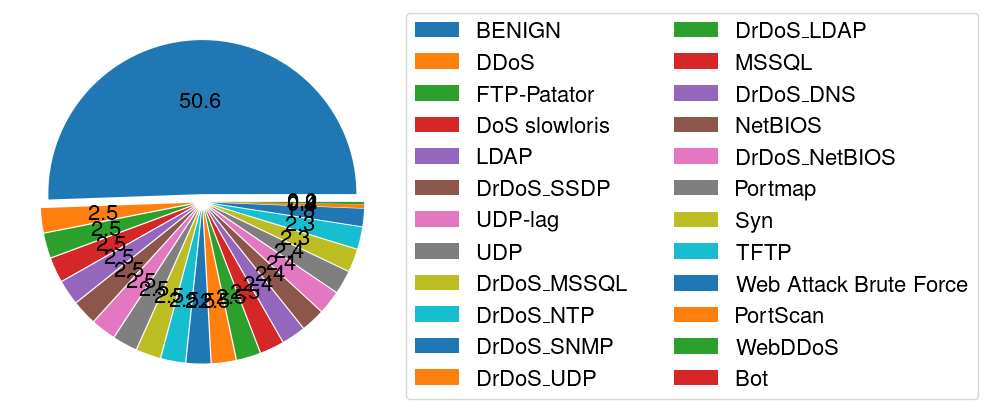

In [6]:
v = unified._y.value_counts()
v_perc = {k: f"{k} ({v})" for k, v in (unified._y.value_counts(normalize=True) * 100).round(2).items()}
ax = v.plot.pie(legend=True, ylabel="", explode=(0.05,)*len(v), labeldistance=None, autopct='%1.1f%%', figsize=(20, 5))
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left', ncol=2)
plt.savefig(f"{config.output_path}/correlations.pdf", bbox_inches="tight")
display(plt.gcf())
plt.close()

Clearly, it shows that the Benign and Malicious samples are balanced, but within the Malicious traffic there are many classes with just few samples, such as for *Heartbleed*.

For each combination of traffic category and for each feature column compute Jensen Shannon distance.

In [7]:
result = pd.read_csv(f"{config.output_path}/seed_{DEFAULT_SEED}_output/jensenshannon_perfeature.csv", index_col=[0, 1])

In [8]:
m = result.T.describe().loc["mean"]
most_similar = m[m < 0.5]
most_different = m[m >= 0.5]

In [9]:
it = (k for k in most_different.sort_values(ascending=False).keys().values if "BENIGN" in k[0] or "BENIGN" in k[1])
list(it)

[('BENIGN', 'Bot'),
 ('BENIGN', 'DDoS'),
 ('BENIGN', 'DoS slowloris'),
 ('BENIGN', 'FTP-Patator'),
 ('DrDoS_UDP', 'BENIGN'),
 ('BENIGN', 'Web Attack Brute Force'),
 ('DrDoS_SNMP', 'BENIGN'),
 ('BENIGN', 'NetBIOS'),
 ('BENIGN', 'UDP'),
 ('BENIGN', 'DrDoS_LDAP'),
 ('BENIGN', 'DrDoS_NTP'),
 ('BENIGN', 'UDP-lag'),
 ('BENIGN', 'Portmap'),
 ('BENIGN', 'PortScan'),
 ('BENIGN', 'DrDoS_MSSQL'),
 ('BENIGN', 'DrDoS_NetBIOS'),
 ('BENIGN', 'LDAP'),
 ('BENIGN', 'DrDoS_DNS'),
 ('BENIGN', 'MSSQL')]

In [10]:
chosen_far = ('BENIGN', 'DDoS')

In [11]:
result.loc[chosen_far].T.describe()

count    61.000000
mean      0.557037
std       0.237247
min       0.009011
25%       0.416695
50%       0.658688
75%       0.748399
max       0.832332
Name: (BENIGN, DDoS), dtype: float64

## Train results

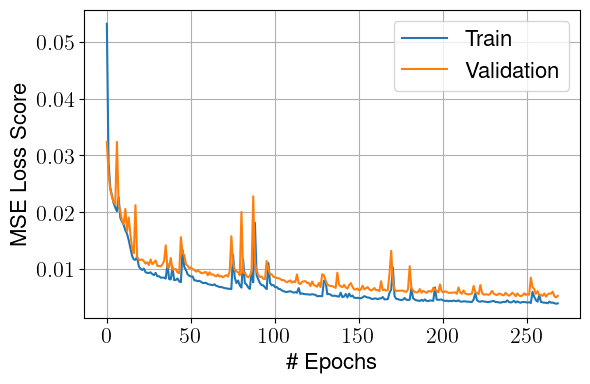

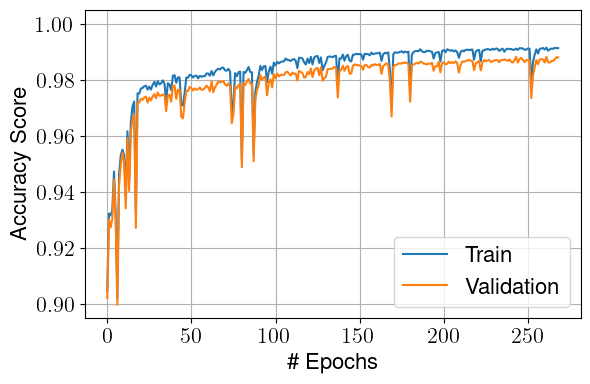

In [8]:
history_df = load(f"{config.output_path}/seed_{DEFAULT_SEED}_output/oracle_history.csv", index_col=0)
ax = history_df[["loss_train", "loss_validation"]].plot(ylabel="MSE Loss Score", xlabel="\# Epochs")
ax.legend(["Train", "Validation"])
ax.grid()
plt.savefig(f"{config.output_path}/seed_{DEFAULT_SEED}_output/train_loss.pdf", bbox_inches="tight")
display(plt.gcf())
plt.close()
ax = history_df[["accuracy_score_train", "accuracy_score_validation"]].plot(ylabel="Accuracy Score", xlabel="\# Epochs")
ax.legend(["Train", "Validation"])
ax.set_ylim(top=1.005)
ax.grid()
plt.savefig(f"{config.output_path}/seed_{DEFAULT_SEED}_output/train_acc.pdf", bbox_inches="tight")
display(plt.gcf())
plt.close()

## Rank and Prune

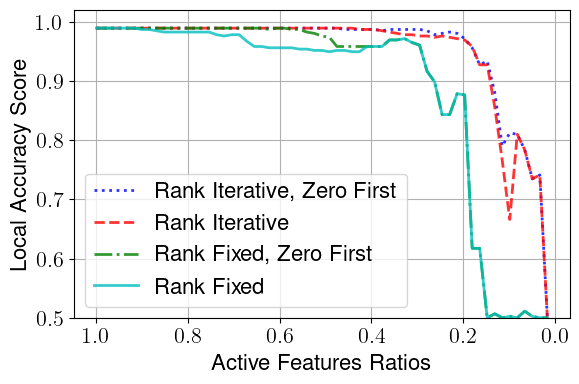

In [9]:
def plot_sequential_elimination_outcome(all_categories=False):
    new_df = pd.DataFrame()
    p = "all_c" if all_categories else "few_c"
    p_camelized = "".join(x.capitalize() for x in p.lower().split("_"))
    b = baselines.loc[f"('{p_camelized}', 'Test')"]["Global"]
    for p1 in ("iterative_rank", "fixed_rank"):
        for p2 in ("zero_first", "zero_not_first"):
            new_df[" ".join(x.capitalize() for x in p1.split("_")[::-1]) +
                   ("" if p2 == "zero_not_first" else ", " + " ".join(x.capitalize() for x in p2.split("_")))] = load(
                f"{config.output_path}/seed_{DEFAULT_SEED}_output/ranking/recursive_ss_{p}_{p1}_{p2}_scores.csv",
                index_col=0)["Global"]
    new_df.index = new_df.index / test.n_features
    ax = new_df.plot(alpha=0.8, style=['b:', 'r--', 'g-.', 'c-'], linewidth=2,
                     xlabel="Active Features Ratios", ylabel="Local Accuracy Score", figsize=(6.4, 4))
    ax.legend(loc="lower left")
    ax.set_ylim(bottom=MIN_ACC, top=1.02)
    ax.invert_xaxis()
    ax.grid()
    plt.savefig(f"{config.output_path}/seed_{DEFAULT_SEED}_output/recursive_ss_{p}.pdf", bbox_inches="tight")
    display(plt.gcf())
    plt.close()

plot_sequential_elimination_outcome()

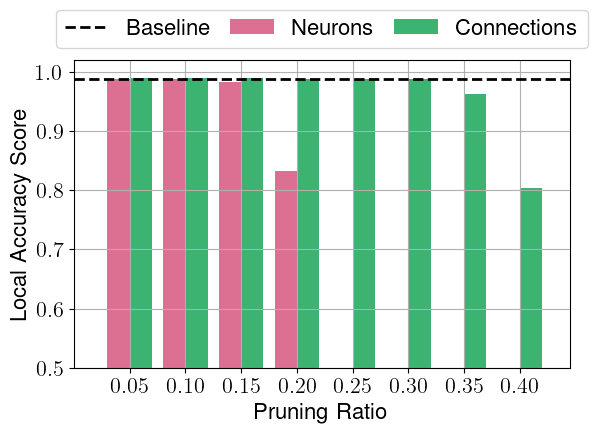

,Prune Ratio,Inference Time (ns),Memory (KB)
0,0.0,307.469802,323.015625
1,0.05,300.876029,287.828125
2,0.1,292.612981,262.750000
3,0.15,289.161507,238.796875
4,0.2,283.884064,215.968750
5,0.25,269.911907,194.265625
6,0.3,263.363158,167.078125
7,0.35,257.578893,148.000000
8,0.4,246.202257,130.046875
9,0.45,243.674279,113.218750


In [10]:
def pruning_only(all_categories=False):
    p = "all_c" if all_categories else "few_c"
    p_camelized = "".join(x.capitalize() for x in p.lower().split("_"))
    cols = ["Global"] if all_categories else config.client_categories
    ds = test if all_categories else test.filter_categories(config.client_categories)

    def get_size(n_input, n_hid_units, n_layers, data_size=8):
        coefs = data_size * ((n_input * n_hid_units) + (n_hid_units*n_hid_units*n_layers) + n_hid_units)
        intercepts = data_size * (n_hid_units*(n_layers+1)+1)
        return (coefs + intercepts)*2 / 1024

    v: pd.DataFrame = load(
        f"{config.output_path}/seed_{DEFAULT_SEED}_output/ranking/traffic_{p}_pruning_ratios_only_globally_neurons_l1.csv",
        index_col=0)
    v = v.sort_values(by="Prune Ratio")
    v2 = load(
        f"{config.output_path}/seed_{DEFAULT_SEED}_output/ranking/traffic_{p}_pruning_ratios_only_globally_unstructured_connections_l1.csv",
        index_col=0)
    v2 = v2.sort_values(by="Prune Ratio")

    vx: pd.DataFrame = v[cols].apply(lambda x: x.between(MIN_ACC, 1.)).all(axis=1)
    vx2: pd.DataFrame = v2[cols].apply(lambda x: x.between(MIN_ACC, 1.)).all(axis=1)
    v["Global"] *= 1*vx
    v2["Global"] *= 1*vx2
    v.rename(columns={"Prune Ratio": "Pruning Ratio", "Global": "Neurons"}, inplace=True)
    v2.rename(columns={"Prune Ratio": "Pruning Ratio", "Global": "Connections"}, inplace=True)
    last_index = max(vx[vx == True].index[-1], vx2[vx2 == True].index[-1])
    ax = v.plot.bar(x="Pruning Ratio", y="Neurons", ylabel="Local Accuracy Score",
                    legend=False, position=1, width=.4, rot=0., color="palevioletred")
    ax = v2.plot.bar(x="Pruning Ratio", y="Connections", ylabel="Local Accuracy Score", legend=False,
                     position=0, width=.4, ax=ax, rot=0., color="mediumseagreen")
    
    ax.set_xticklabels([f'$\\mathdefault{x:.2f}$' for x in v["Pruning Ratio"]])

    ax.set_ylim(bottom=MIN_ACC, top=1.02)
    ax.set_xlim(left=-1, right=7.9)
    ax.grid()
    ax.hlines(y=baselines.loc[f"('{p_camelized}', 'Validation')"]["Global"], xmin=-1, xmax=last_index+1,
              linestyles="dashed", linewidth=2, color='k', label="Baseline")
    ax.legend(loc="center", bbox_to_anchor=(0.5, 1.1), ncols=3,
              handler_map={tuple: HandlerTuple(ndivide=None)}, labelspacing=0., columnspacing=0.8)
    
    plt.savefig(f"{config.output_path}/seed_{DEFAULT_SEED}_output/pruning_only_{p}.pdf", bbox_inches="tight")
    display(plt.gcf())
    plt.close()
    
    m_normal = load(f"{config.output_path}/seed_{DEFAULT_SEED}_output/zevaluations/evaluation_full.json")
    v_normal = get_size(ds.n_features, config.n_hidden_units, config.n_hidden_layers)
    df = pd.DataFrame(columns=["Prune Ratio", "Inference Time (ns)", "Memory (KB)"])
    df.loc[len(df)] = ["0.0", np.mean(m_normal)/ds.n_samples, v_normal]

    amounts = v["Pruning Ratio"]
    
    for p in amounts:
        m_pruned = pd.Series(
            load(f"{config.output_path}/seed_{DEFAULT_SEED}_output/zevaluations/evaluation_pruned_{p}.json"))
        m_pruned = m_pruned[m_pruned.apply(lambda j: j >= m_pruned.quantile(.1) and j <= m_pruned.quantile(.75))]
        new_hidden_units = int(config.n_hidden_units * (1-p))
        v_pruned = get_size(ds.n_features, new_hidden_units, config.n_hidden_layers)
        df.loc[len(df)] = [f"{p}", np.mean(m_pruned)/ds.n_samples, v_pruned]
    df.to_latex(f"{config.output_path}/seed_{DEFAULT_SEED}_output/evaluation.tex",
                index=False, float_format="{:0.0f}".format)
    display(df)

pruning_only()

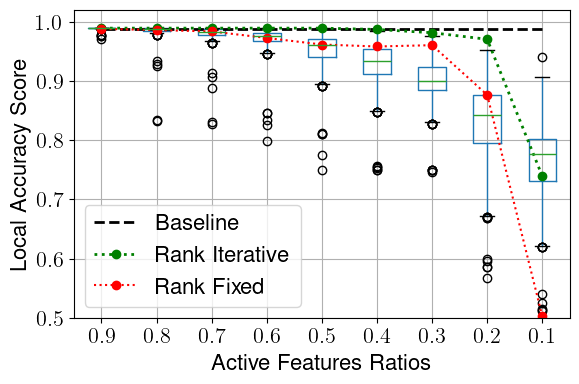

In [11]:
def plot_different_subsets_only_found(all_categories=False):
    p = "all_c" if all_categories else "few_c"
    p_camelized = "".join(x.capitalize() for x in p.lower().split("_"))

    tmp = {}
    cols = ["Global"] if all_categories else config.client_categories
    tmp = {
        round(x * validation.n_features):
        load(
            f"{config.output_path}/seed_{DEFAULT_SEED}_output/ranking/rank_{p}_traffic_{p}_subsetsize_{x}_scores.csv",
            index_col=0) for x in config.target_subset_ratios}
    for k, v in tmp.items():
        accepted: pd.DataFrame = v[v[cols].apply(lambda x: x.between(MIN_ACC, 1.)).all(axis=1)]
        tmp[k] = v.loc[accepted.index]
    asd = pd.DataFrame({k: v["Global"] for k, v in tmp.items()})
    ax, bp = asd.boxplot(ylabel="Local Accuracy Score", xlabel="Active Features Ratios", return_type='both', figsize=(6.4, 4))
    # Iterate over it!
    for fly in bp['fliers']:
        fdata = fly.get_data()
        tmp = []
        for x in fdata:
            if len(x) < 1:
                tmp.append([None, None])
                continue
            x = list(sorted(x))
            tmp.append(x[:5] + x[-5:])
        fly.set_data(tmp)
    ax.set_xticklabels([str(x) for x in config.target_subset_ratios])
    ax.hlines(y=baselines.loc[f"('{p_camelized}', 'Validation')"]["Global"], xmin=1, xmax=len(
        config.target_subset_ratios), linestyles="dashed", linewidth=2, color='k', label="Baseline")
    ax.set_ylim(bottom=0.5, top=1.02)
    ax.set_xticklabels([f'$\\mathdefault{x:.1f}$' for x in config.target_subset_ratios])
    ax.invert_xaxis()
    sz = [round(x*validation.n_features) for x in config.target_subset_ratios]
    b = load(
        f"{config.output_path}/seed_{DEFAULT_SEED}_output/ranking/recursive_ss_{p}_iterative_rank_zero_first_scores.csv",
        index_col=0).loc[sz, "Global"].reset_index(drop=True)
    b += load(f"{config.output_path}/seed_{DEFAULT_SEED}_output/ranking/recursive_ss_{p}_iterative_rank_zero_not_first_scores.csv",
              index_col=0).loc[sz, "Global"].reset_index(drop=True)
    b /= 2
    b.index += 1
    ax = b.plot(ax=ax, style="go:", label="Rank Iterative", grid=True, linewidth=2)
    b = load(
        f"{config.output_path}/seed_{DEFAULT_SEED}_output/ranking/recursive_ss_{p}_fixed_rank_zero_first_scores.csv",
        index_col=0).loc[sz, "Global"].reset_index(drop=True)
    b += load(f"{config.output_path}/seed_{DEFAULT_SEED}_output/ranking/recursive_ss_{p}_fixed_rank_zero_not_first_scores.csv",
              index_col=0).loc[sz, "Global"].reset_index(drop=True)
    b /= 2
    b.index += 1
    ax = b.plot(ax=ax, style="ro:", label="Rank Fixed", grid=True)
    ax.legend(loc="lower left")
    plt.savefig(f"{config.output_path}/seed_{DEFAULT_SEED}_output/subsets_only_{p}.pdf", bbox_inches="tight")
    display(plt.gcf())
    plt.close()


plot_different_subsets_only_found()

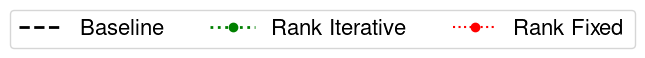

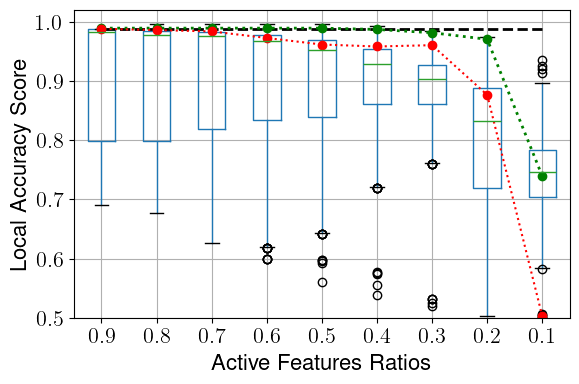

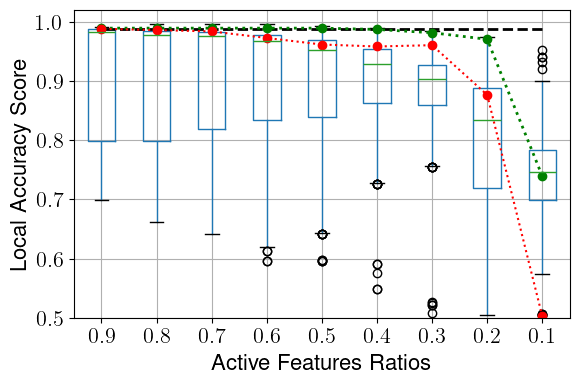

In [6]:
def plot_different_subsets_and_pruning(all_categories=False, prune_first=True, ax=None):
    show = ax is None 
    p = "all_c" if all_categories else "few_c"
    p_camelized = "".join(x.capitalize() for x in p.lower().split("_"))
    cols = ["Global"] if all_categories else config.client_categories
    tmp = {
        round(x * validation.n_features):
        load(
            f"{config.output_path}/seed_{DEFAULT_SEED}_output/ranking/rank_{p}_traffic_{p}_combo_pruned_models_subsetsize_{x}_{config.prune_method.__name__}_scores.csv"
            if prune_first else \
            f"{config.output_path}/seed_{DEFAULT_SEED}_output/ranking/rank_{p}_traffic_{p}_combo_subsetsize_{x}_pruned_models_{config.prune_method.__name__}_scores.csv"
            ,index_col=0) for x in config.target_subset_ratios}

    for k, v in tmp.items():
        accepted: pd.DataFrame = v[v[cols].apply(lambda x: x.between(MIN_ACC, 1.)).all(axis=1)]
        tmp[k] = v.loc[accepted.index]
    asd = pd.DataFrame({k: v["Global"] for k, v in tmp.items()})
    ax, bp = asd.boxplot(ylabel="Local Accuracy Score", xlabel="Active Features Ratios", return_type='both', figsize=(6.4, 4), ax=ax)
    for fly in bp['fliers']:
        fdata = fly.get_data()
        tmp2 = []
        for x in fdata:
            if len(x) < 1:
                tmp2.append([None, None])
                continue
            x = list(sorted(x))
            tmp2.append(x[:5] + x[-5:])
        fly.set_data(tmp2)
    ax.set_xticklabels([str(x) for x in config.target_subset_ratios])
    ax.hlines(y=baselines.loc[f"('{p_camelized}', 'Validation')"]["Global"], xmin=1, xmax=len(
        config.target_subset_ratios), linestyles="dashed", linewidth=2, color='k', label="Baseline")
    ax.set_ylim(bottom=MIN_ACC, top=1.02)
    ax.set_xticklabels([f'$\\mathdefault{x:.1f}$' for x in config.target_subset_ratios])
    ax.invert_xaxis()
    sz = [round(x*validation.n_features) for x in config.target_subset_ratios]
    b = load(
        f"{config.output_path}/seed_{DEFAULT_SEED}_output/ranking/recursive_ss_{p}_iterative_rank_zero_first_scores.csv",
        index_col=0).loc[sz, "Global"].reset_index(drop=True)
    b += load(f"{config.output_path}/seed_{DEFAULT_SEED}_output/ranking/recursive_ss_{p}_iterative_rank_zero_not_first_scores.csv",
              index_col=0).loc[sz, "Global"].reset_index(drop=True)
    b /= 2
    b.index += 1
    ax = b.plot(ax=ax, style="go:", label="Rank Iterative", grid=True, linewidth=2)
    b = load(
        f"{config.output_path}/seed_{DEFAULT_SEED}_output/ranking/recursive_ss_{p}_fixed_rank_zero_first_scores.csv",
        index_col=0).loc[sz, "Global"].reset_index(drop=True)
    b += load(f"{config.output_path}/seed_{DEFAULT_SEED}_output/ranking/recursive_ss_{p}_fixed_rank_zero_not_first_scores.csv",
              index_col=0).loc[sz, "Global"].reset_index(drop=True)
    b /= 2
    b.index += 1
    ax = b.plot(ax=ax, style="ro:", label="Rank Fixed", grid=True)

    ax.legend(loc="lower center", bbox_to_anchor=(0.5, 1.15), ncols=3,
              labelspacing=0., columnspacing=0.8, frameon=True)
    ax.get_legend().set_visible(show)
    return ax

fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()

plot_different_subsets_and_pruning(prune_first=True, ax=ax)
plot_different_subsets_and_pruning(prune_first=False, ax=ax2);
handles, labels = ax2.get_legend_handles_labels()
f, o = plt.subplots()
o.set_visible(False)
f.legend(handles, labels, loc="center", bbox_to_anchor=(0.5, 1.1), ncols=len(handles))
f.savefig(f"{config.output_path}/seed_{DEFAULT_SEED}_output/legend.pdf", bbox_inches="tight")
fig.savefig(f"{config.output_path}/seed_{DEFAULT_SEED}_output/combo_prunefirst.pdf", bbox_inches="tight")
fig2.savefig(f"{config.output_path}/seed_{DEFAULT_SEED}_output/combo_subsetfirst.pdf", bbox_inches="tight")
display(f)
display(fig)
display(fig2)
plt.close(fig)
plt.close(fig2)
plt.close(f)

## Test

In [6]:
def knowledge_loss_gain_score(df: pd.DataFrame, eval_after, eval_before, seen_categories=None,
                              func_weights: tuple[float] = None, ignore_categories: list[str] = None) -> pd.Series:
    """Function to measure with different indicators the knowledge loss/gain with respect to
    a baseline scenario, also provided in the dataframe.

    Args:
        df (pd.DataFrame): dataframe with data to be compared
        func_weights (tuple[float], optional): list of weights to assign to each
            indicator. Defaults to None.
        ignore_categories (list[str], Optinal): list of optional categories to exclude
            during the computation of the metrics. Default to None.

    Returns:
        pd.Series: a series containing all the indicators and the final evaluation function score.
    """
    if ignore_categories is None:
        ignore_categories = []
    df = df[df.columns.difference(ignore_categories + ['Global'])]

    if func_weights is None:
        func_weights = [0.25] * 4

    df = df[df.columns.difference(['Global'])]
    if seen_categories is None:
        seen_categories = df.columns.values

    seen = df[df.columns.intersection(seen_categories)].columns.values
    unseen = df[df.columns.difference(seen_categories)].columns.values

    seen_proportions = pd.Series([1/len(seen)]*len(seen), index=seen)
    if unseen.size:
        unseen_proportions = pd.Series([1/len(unseen)]*len(unseen), index=unseen)

    def f(after, before):
        diff = df.loc[after] - df.loc[before]
        diff_seen = diff[seen]
        diff_unseen = diff[unseen]

        loss_seen = diff_seen[diff_seen < 0]
        loss_seen = (loss_seen*seen_proportions).sum()
        gain_seen = diff_seen[diff_seen > 0]
        gain_seen = (gain_seen*seen_proportions).sum()

        loss_unseen = gain_unseen = 0
        if unseen.size:
            loss_unseen = diff_unseen[diff_unseen < 0]
            loss_unseen = (loss_unseen*unseen_proportions).sum()
            gain_unseen = diff_unseen[diff_unseen > 0]
            gain_unseen = (gain_unseen*unseen_proportions).sum()
        else:
            to_add = func_weights[2] / 2 + func_weights[3] / 2
            func_weights[2] = func_weights[3] = 0.
            func_weights[0] += to_add
            func_weights[1] += to_add

        factors = [loss_seen, gain_seen, loss_unseen, gain_unseen]

        return pd.Series([sum(factors[i] * func_weights[i] for i in range(len(factors)))] + factors,
                         index=['Func', 'Loss Seen', 'Gain Seen', 'Loss Unseen', 'Gain Unseen'])
    return f(eval_after, eval_before)

def get_name(scenario, availability, learn_input):
    base = config.output_path + f"/seed_{DEFAULT_SEED}_output/{scenario}"
    ret = {"HT": ContinuouLearningAlgorithm.ground_truth.name,
           "HD": ContinuouLearningAlgorithm.knowledge_distillation.name,
           "HI": ContinuouLearningAlgorithm.ground_inferred.name,
           "KD": ContinuouLearningAlgorithm.knowledge_distillation.name}
    for entry, alg in ret.items():
        extra = ""
        if alg == ContinuouLearningAlgorithm.knowledge_distillation.name:
            if entry == "HD":
                extra = "-learn_kwargs_{'alpha': 0.5}"
            else:
                extra = "-learn_kwargs_{'alpha': 1}"
        f_av_fixed = availability
        if alg == ContinuouLearningAlgorithm.ground_truth.name and (
                "_eo" in scenario or "_ec" in scenario) and learn_input.name == InputForLearn.client.name:
            f_av_fixed = FeatureAvailability.none
        ret[entry] = f"{base}/algorithm_{alg}-availability_{f_av_fixed.name}-learn_input_{learn_input.name}{extra}-max_epochs_{config.common_parameters['max_epochs']}-epochs_wo_improve_{config.common_parameters['epochs_wo_improve']}-batch_size_{config.batch_size}"
    return ret

def plot_thorugh_time_during_test_eval_metrics(cases, savename=None, ax=None, ax2=None):
    show = False if ax is not None else True
    tmp2 = {}
    for name, pat in cases.items():
        f2 = load(pat + ".csv", index_col=0)
        f2.loc["Max Baseline"] = baselines.loc["('AllC', 'Test')"]
        tmp2[name] = f2.copy(deep=True)

    loss_before,loss_before_teach  = None, None
    for k, v in list(tmp2.items())[-1:]:
        loss_before = knowledge_loss_gain_score(
            v, "Test Before", "Max Baseline", seen_categories=config.client_categories if "few_c" in pat else None).abs()["Loss Unseen"]
        loss_before_teach = knowledge_loss_gain_score(
            v, "Oracle Test", "Max Baseline", seen_categories=config.client_categories if "few_c" in pat else None).abs()["Loss Unseen"]
        
        break
    asd2 = pd.DataFrame({k: v["Global"] for k, v in tmp2.items()}).T
    x = {
        k:
        knowledge_loss_gain_score(
            v, "Test After", "Max Baseline", seen_categories=config.client_categories if "few_c" in pat else None)
        for k, v in tmp2.items()}
    orac = asd2.pop("Oracle Test")
    bef = asd2.pop("Test Before")
    asd2.pop("Max Baseline")
    asd2.rename(columns={"Test After": "Student Fine-tuned Score/Loss"}, inplace=True)
    ax = asd2.plot.bar(ylabel="Global Accuracy Score", xlabel="Learning Algorithms",
                       rot=0, position=1, legend=False, width=.3, ax=ax)
    ax2 = ax2 if ax2 is not None else ax.twinx()
    ajaj = pd.DataFrame(x).T["Loss Unseen"].abs()
    ajaj.rename(index="DASDA", inplace=True)

    ajaj.plot.bar(ax=ax2, ylabel="Historical Accuracy Loss", xlabel="Learning Algorithms",
                  rot=0, position=0, legend=False, width=.3, color="darkorange")
    ax2.set_ylim(top=.52, bottom=-.01)
    ax2.hlines(y=loss_before_teach, xmin=-.6, xmax=3.5, linestyles='dashed', linewidth=3, color='maroon', label="Loss Student")
    ax2.hlines(y=loss_before, xmin=-.6, xmax=3.5, linestyles='dotted', linewidth=3, color='red', label="Loss Teacher")
    ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.])
    ax2.set_yticks([0., 0.1, 0.2, 0.3, 0.4, 0.5])
    for i, rect in enumerate(ax2.patches):
        height = rect.get_height()
        if height < MIN_ACC + 0.02:
            continue
        height = MIN_ACC + 0.01
        ax2.scatter(x=[i+0.15], y=[height], marker=10, c="k", s=40)

    ax.set_xlim(left=-.5, right=3.5)
    ax.set_ylim(top=1.02, bottom=MIN_ACC - 0.01)

    for xt in ax.get_xticks():
        ax.fill_between(x=[xt-.3,xt], y1=.4, y2=MIN_ACC, color="white")

    ax.hlines(y=bef.max(), xmin=-.6, xmax=3.5, linestyles='dashed', linewidth=3, color='teal', label="Score Student")
    ax.hlines(y=orac.max(), xmin=-.6, xmax=3.5, linestyles='dotted', linewidth=3, color='darkblue', label="Score Teacher")
    
    ax.plot(np.NaN, np.NaN, '-', color='none', label='a')
    ax.plot(np.NaN, np.NaN, '-', color='none', label='b')

    ax.grid(axis="y")
    handles_labels = [ax.get_legend_handles_labels() for ax in (ax, ax2)]
    hl_transposed = zip(*handles_labels)
    handles, _ = [sum(handles_or_labels, [])
                       for handles_or_labels in hl_transposed]
    
    handles1 = [handles[5], handles[6], handles[0], handles[1], handles[4], handles[7]]
    labels1 = ["Loss Teacher", "Loss Student", "Score Teacher", "Score Student", "Student Fine-tuned Score", "Student Fine-tuned Loss"]
    ax.legend(handles1, labels1, loc="lower center", bbox_to_anchor=(0.5, 1.), ncols=len(handles),
              handler_map={tuple: HandlerTuple(ndivide=None)}, labelspacing=0., columnspacing=0.8, frameon=True)
    ax.get_legend().set_visible(show)
    if savename is not None:
        plt.savefig(f"{config.output_path}/seed_{DEFAULT_SEED}_output/{savename}.pdf", bbox_inches="tight")
    return handles1, labels1

def multiplot(fnames, savename, take_third=False, save_axes=True):
    for i, (av, inp) in enumerate((
        (FeatureAvailability.none, InputForLearn.client),
        (FeatureAvailability.oracle, InputForLearn.client),
        (FeatureAvailability.oracle, InputForLearn.oracle),
        (FeatureAvailability.oracle, InputForLearn.mixed))):
        for j, fname in enumerate(fnames):
            tmp = fname.split("_")[-3] if take_third else fname.split("_")[-1]
            fig, ax = plt.subplots()
            twin = ax.twinx()
            plot_thorugh_time_during_test_eval_metrics(
                get_name(fname, av, inp), ax=ax, ax2=twin)
            if save_axes:
                if j == 0:
                    twin.set_ylabel(twin.get_ylabel(), color="white")
                elif j+1 == len(fnames):
                    ax.set_ylabel(ax.get_ylabel(), color="white")
                else:
                    ax.set_ylabel(ax.get_ylabel(), color="white")
                    twin.set_ylabel(twin.get_ylabel(), color="white")
            fig.savefig(f"{config.output_path}/seed_{DEFAULT_SEED}_output/{savename}_case{i}_{tmp}_.pdf", bbox_inches="tight")
            display(fig)
            plt.close(fig)

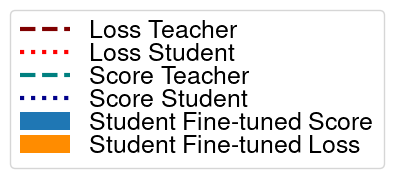

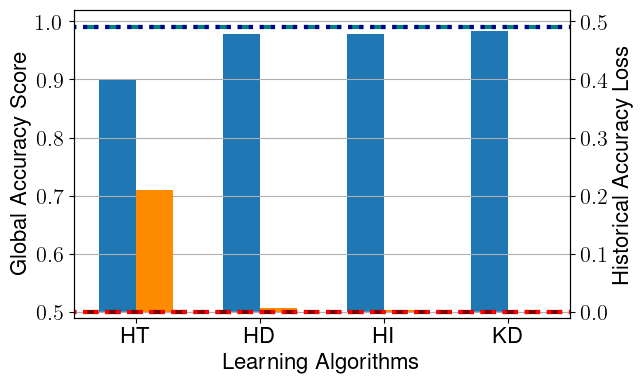

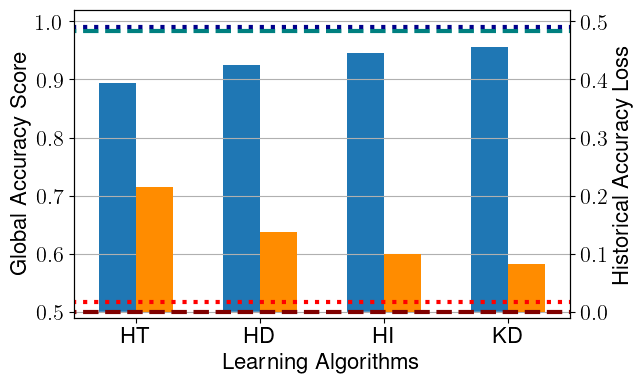

In [11]:
fig, axs = plt.subplots()
fig2, axs2 = plt.subplots()
plot_thorugh_time_during_test_eval_metrics(
    get_name("o_to_o_few_c", FeatureAvailability.bilateral, InputForLearn.client), "o_to_o", ax=axs, ax2=axs.twinx());
handles, labels = plot_thorugh_time_during_test_eval_metrics(get_name(
    "o_to_po_few_c_performance_drop_0.1_prune_0.15", FeatureAvailability.bilateral, InputForLearn.client), "o_to_po", ax=axs2, ax2=axs2.twinx());
def make_leg(ncol=1):
    f, o = plt.subplots()
    o.set_visible(False)
    f.legend(handles, labels, loc="center", bbox_to_anchor=(0.5, 1.1), ncols=ncol, columnspacing=0.5, labelspacing=0., fontsize=18)
    f.savefig(f"{config.output_path}/seed_{DEFAULT_SEED}_output/legend2-{ncol}.pdf", bbox_inches="tight")
    return f

f = make_leg(1)
plt.close(make_leg(len(handles)))
plt.close(make_leg(len(handles)/2))
fig.savefig(f"{config.output_path}/seed_{DEFAULT_SEED}_output/o_to_o.pdf", bbox_inches="tight")
fig2.savefig(f"{config.output_path}/seed_{DEFAULT_SEED}_output/o_to_o.pdf", bbox_inches="tight")
display(f)
display(fig)
display(fig2)
plt.close(fig)
plt.close(fig2)
plt.close(f)

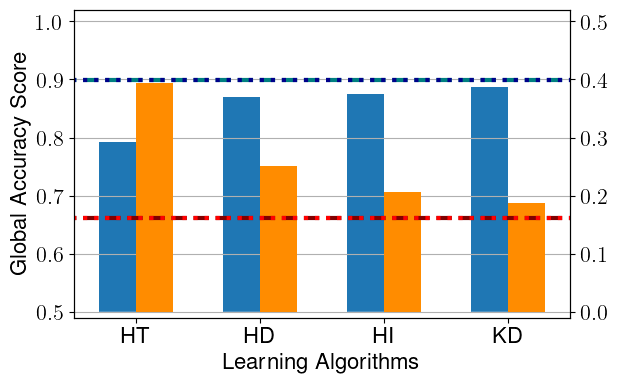

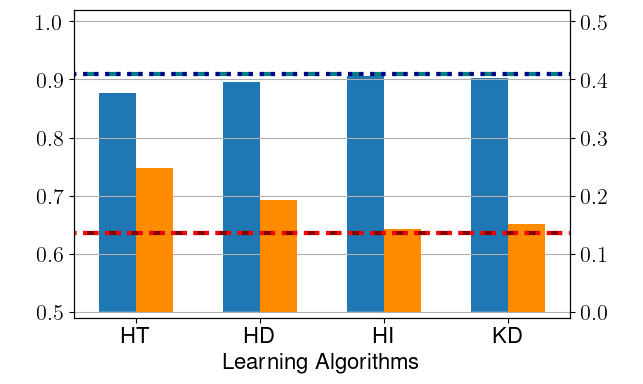

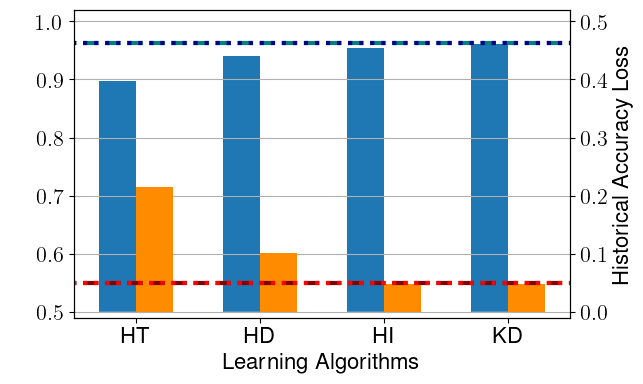

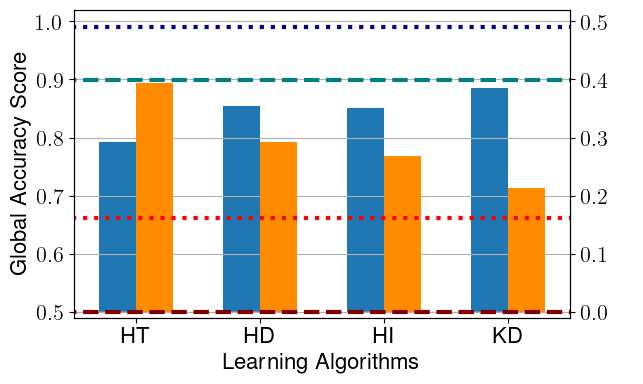

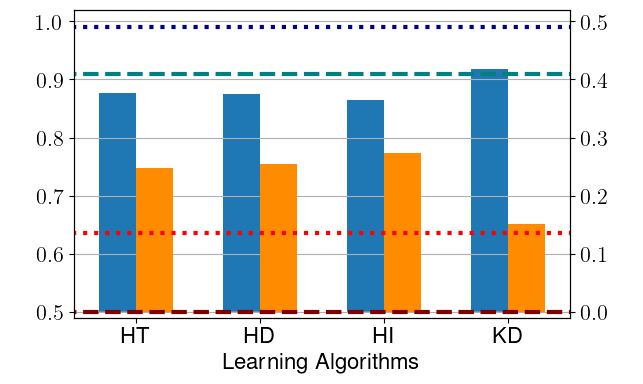

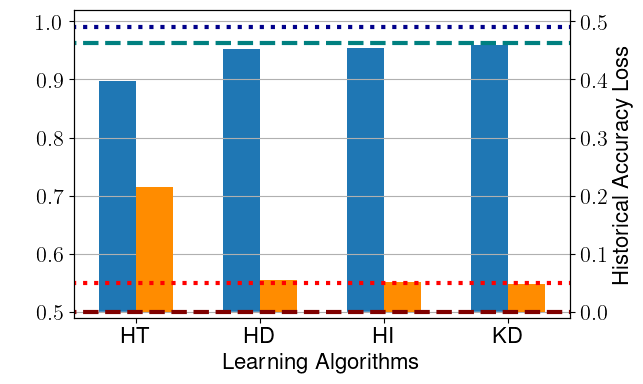

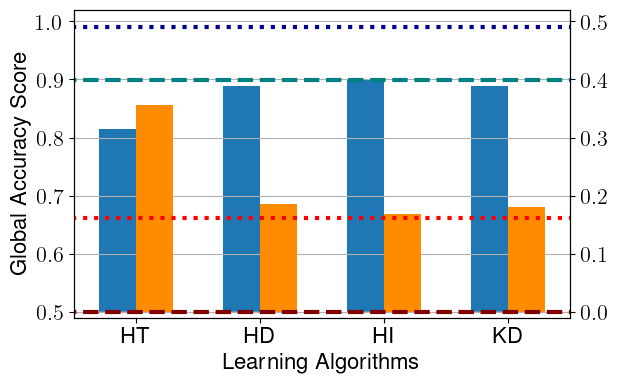

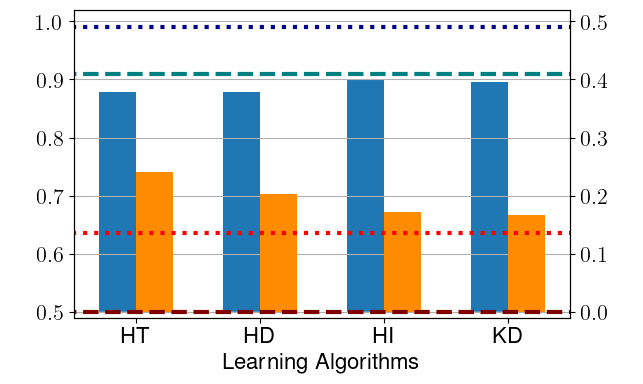

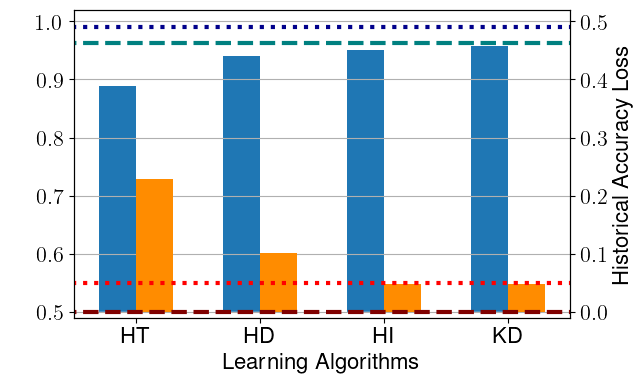

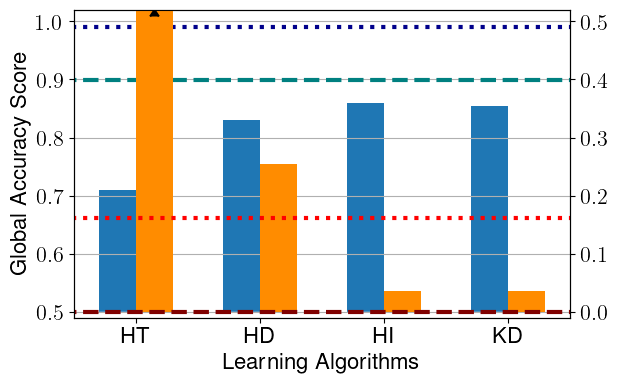

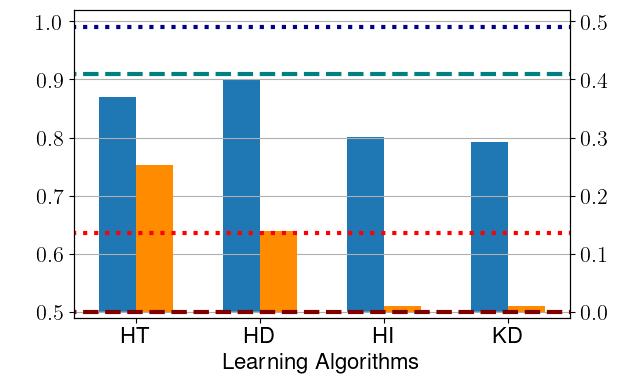

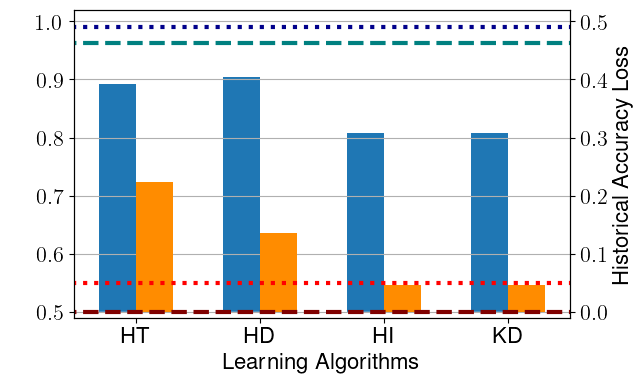

In [8]:
multiplot(["o_to_eo_few_c_performance_drop_0.1_subsetsize_0.3",
            "o_to_eo_few_c_performance_drop_0.1_subsetsize_0.5",
            "o_to_eo_few_c_performance_drop_0.1_subsetsize_0.8"], "o_to_eo", save_axes=True)

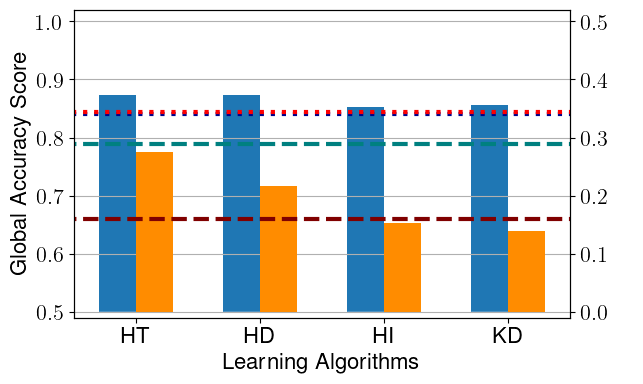

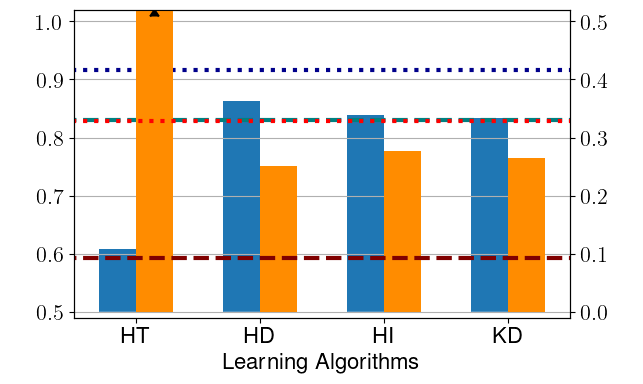

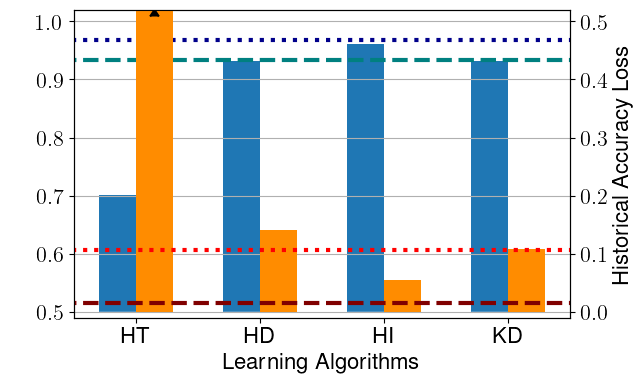

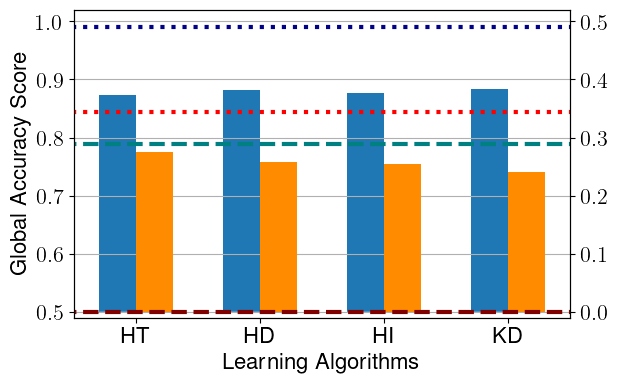

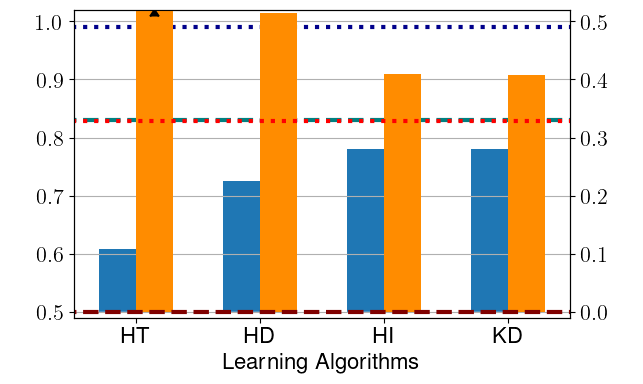

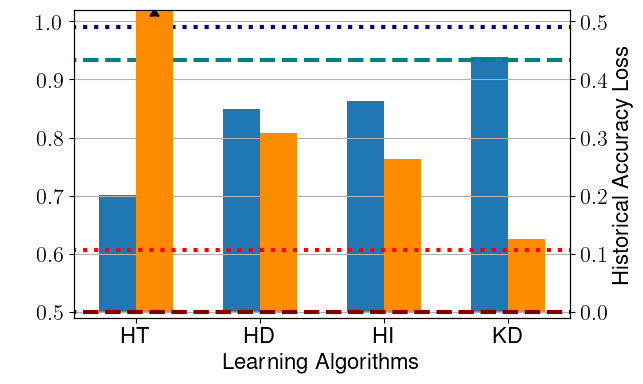

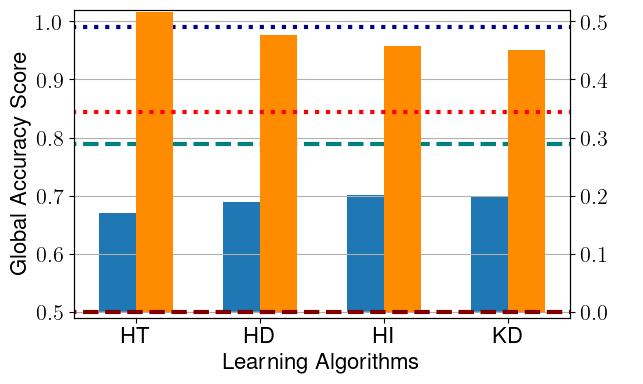

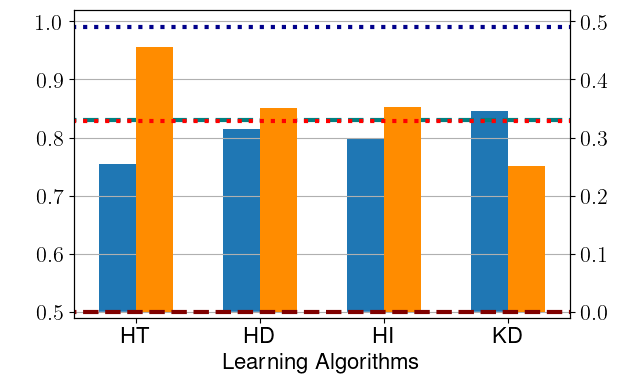

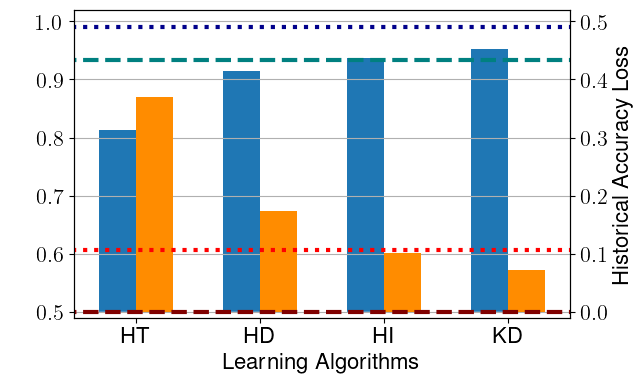

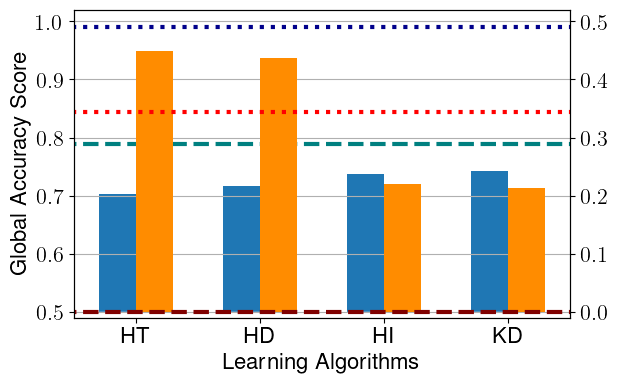

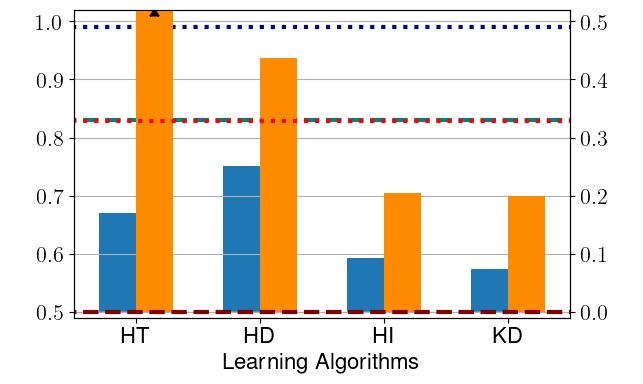

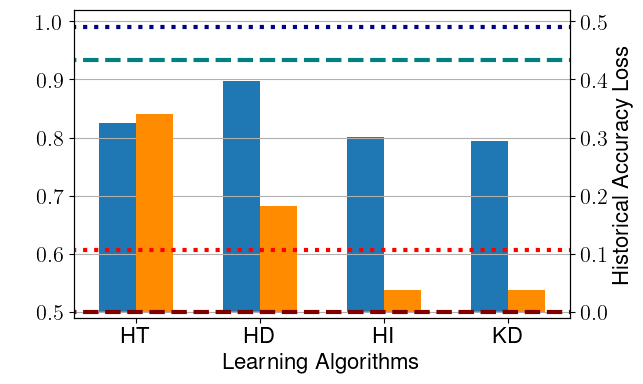

In [9]:
multiplot(["o_to_ec_few_c_performance_drop_0.1_prune_0.25_subsetsize_0.3",
            "o_to_ec_few_c_performance_drop_0.1_prune_0.25_subsetsize_0.5",
            "o_to_ec_few_c_performance_drop_0.1_prune_0.2_subsetsize_0.8"], "o_to_ec_prune_then_subset", save_axes=True)

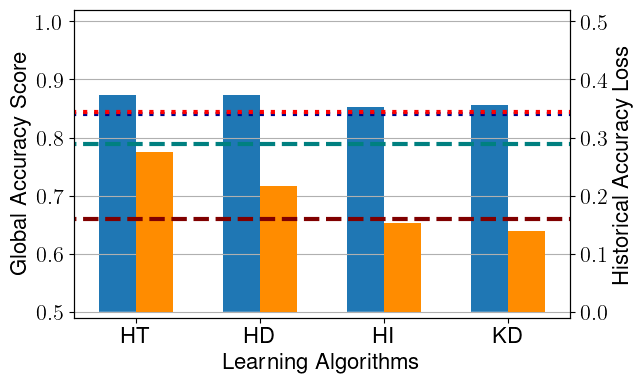

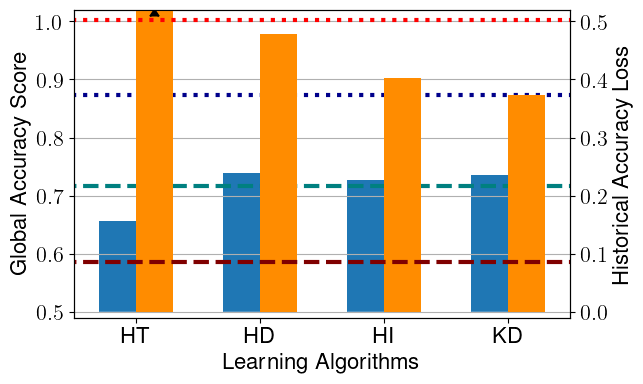

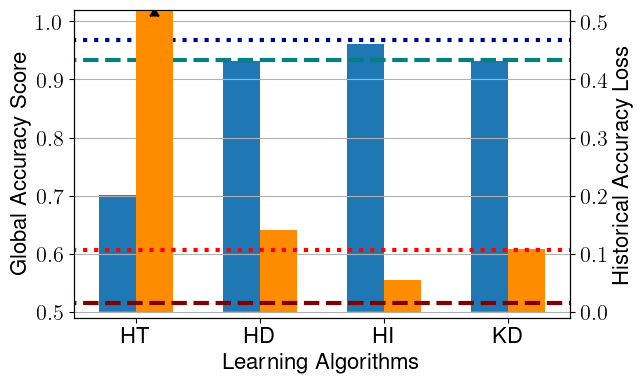

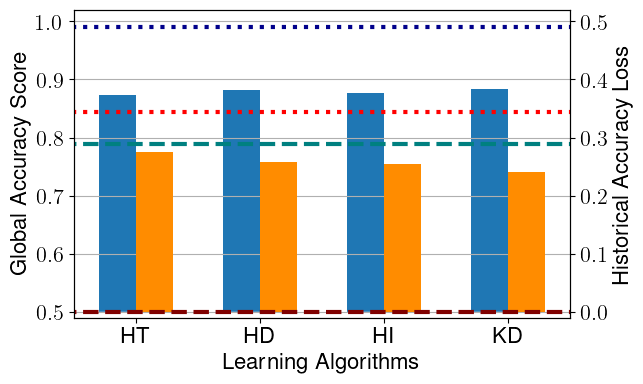

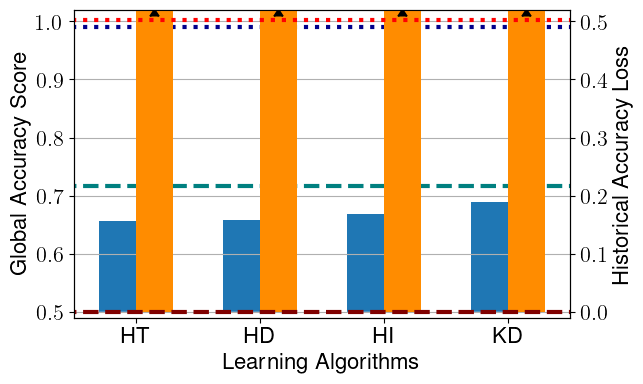

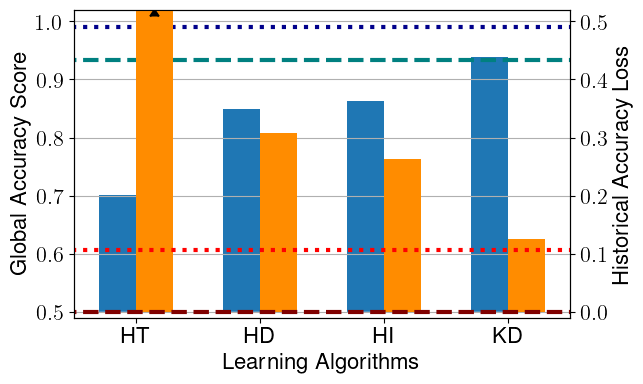

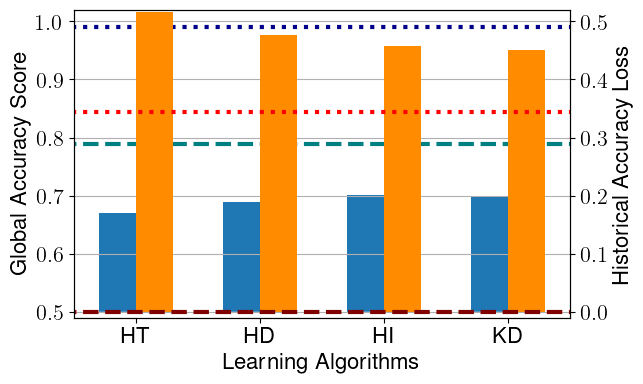

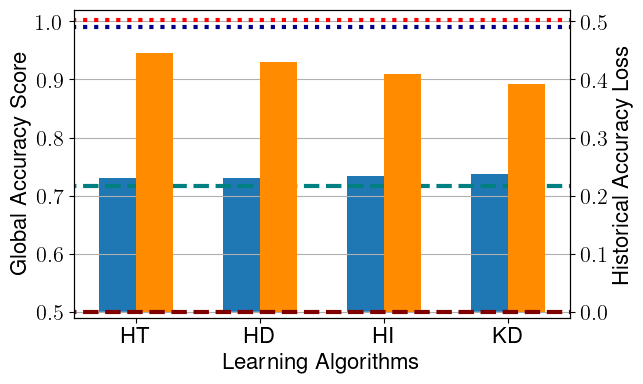

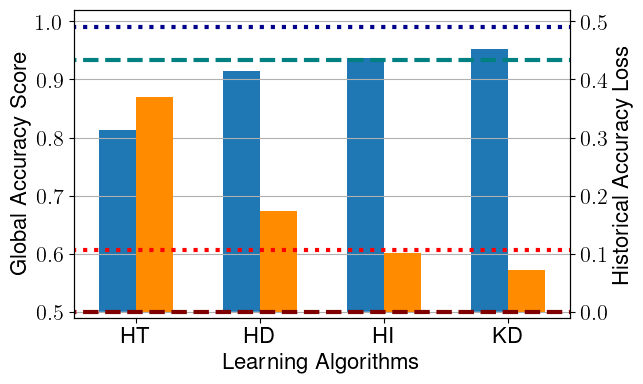

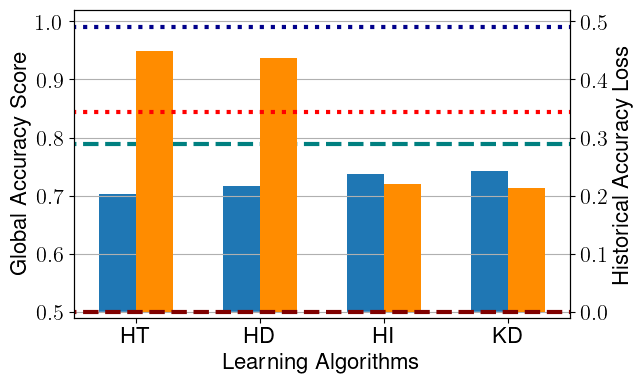

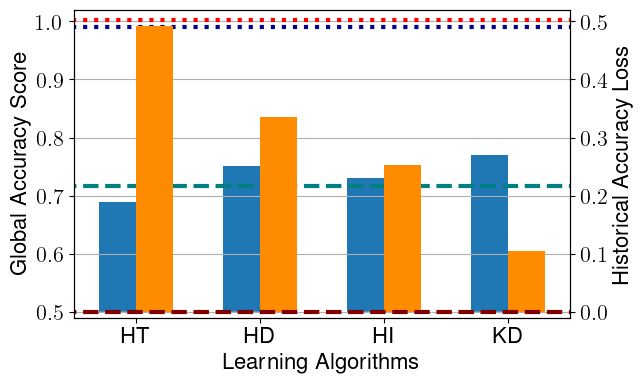

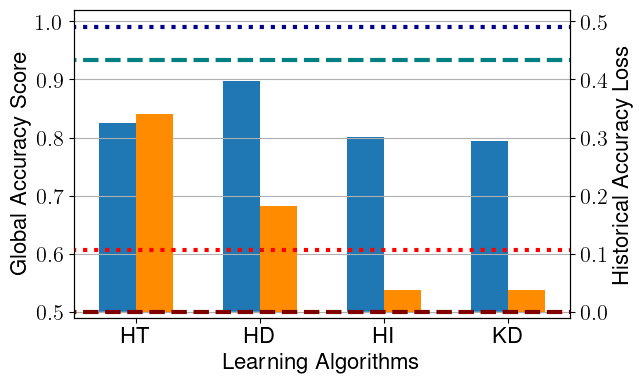

In [10]:
multiplot(["o_to_ec_few_c_performance_drop_0.1_subsetsize_0.3_prune_0.25",
            "o_to_ec_few_c_performance_drop_0.1_subsetsize_0.5_prune_0.25",
            "o_to_ec_few_c_performance_drop_0.1_subsetsize_0.8_prune_0.2"], "o_to_ec_subset_then_prune", take_third=True, save_axes=False)